# **Processing Sequences Using RNNs and CNNs**

Predicting the future is something you do all the time, whether you are finishing a friend’s sentence or anticipating the smell of coffee at breakfast. In this chapter we will discuss recurrent neural networks (RNNs)—a class of nets that can predict the future (well, up to a point). RNNs can analyze time series data, such as the number of daily active users on your website, the hourly temperature in your city, your home’s daily power consumption, the trajectories of nearby cars, and more. Once an RNN learns past patterns in the data, it is able to use its knowledge to forecast the future, assuming of course that past patterns still hold in the future.

More generally, RNNs can work on sequences of arbitrary lengths, rather than on fixed-sized inputs. For example, they can take sentences, documents, or audio samples as input, making them extremely useful for natural language processing applications such as automatic translation or speech-to-text.

In this chapter, we will first go through the fundamental concepts underlying RNNs and how to train them using backpropagation through time. Then, we will use them to forecast a time series. Along the way, we will look at the popular ARMA family of models, often used to forecast time series, and use them as baselines to compare with our RNNs. After that, we’ll explore the two main difficulties that RNNs face:
- Unstable gradients (discussed in Chapter 11), which can be alleviated using various techniques, including *recurrent dropout* and *recurrent layer normalization*.
  
- A (very) limited short-term memory, which can be extended using LSTM and GRU cells.

RNNs are not the only types of neural networks capable of handling sequential data. For small sequences, a regular dense network can do the trick, and for very long sequences, such as audio samples or text, convolutional neural networks can actually work quite well too. We will discuss both of these possibilities, and we will finish this chapter by implementing a WaveNet—a CNN architecture capable of handling sequences of tens of thousands of time steps. Let’s get started!

## **Recurrent Neurons and Layers**
Up to now we have focused on feedforward neural networks, where the activations flow only in one direction, from the input layer to the output layer. A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backward.

Let’s look at the simplest possible RNN, composed of one neuron receiving inputs, producing an output, and sending that output back to itself, as shown in [Figure 15-1](#fig151) (left). At each *time step t* (also called a *frame*), this *recurrent* neuron receives the inputs **x**<sub>(t)</sub> as well as its own output from the previous time step, *ŷ<sub>(t–1)</sub>*  . Since there is no previous output at the first time step, it is generally set to 0. We can represent this tiny network against the time axis, as shown in [Figure 15-1](#fig151) (right). This is called *unrolling the network through time* (it’s the same recurrent neuron represented once per time step).

<span id=fig151></span>
![*A recurrent neuron (left) unrolled through time (right)*](f151.png)

You can easily create a layer of recurrent neurons. At each time step *t*, every neuron receives both the input vector **x**<sub>(t)</sub> and the output vector from the previous time step *ŷ<sub>(t-1)</sub>* , as shown in [Figure 15-2](#fig152). Note that both the inputs and outputs are now vectors (when there was just a single neuron, the output was a scalar).

<span id=fig152></span>
![*A layer of recurrent neurons (left) unrolled through time (right)*](f152.png)

Each recurrent neuron has two sets of weights: one for the inputs **x**<sub>(t)</sub> and the other for the outputs of the previous time step, *ŷ<sub>(t–1)</sub>* . Let’s call these weight vectors **w**<sub>*x*</sub> and **w**<sub>*ŷ*</sub> . If we consider the whole recurrent layer instead of just one recurrent neuron, we can place all the weight vectors in two weight matrices: **W**<sub>*x*</sub> and **W**<sub>*ŷ*</sub>.

The output vector of the whole recurrent layer can then be computed pretty much as you might expect, as shown in [Equation 15-1](#eqn151), where **b** is the bias vector and *ϕ*(·) is the activation function (e.g., **ReLU**).

<span id=eqn151>
![*Output of a recurrent layer for a single instance*](e151.png)

Just as with feedforward neural networks, we can compute a recurrent layer’s output in one shot for an entire mini-batch by placing all the inputs at time step *t* into an input matrix **X**<sub>*(t)*</sub> (see [Equation 15-2](#eqn152)).

<span id=eqn152></span>
![*Outputs of a layer of recurrent neurons for all instances in a pass:[mini-batch]*](e152.png)

In this equation:
- **Ŷ**<sub>(t)</sub> is an *m* × *n<sub>neurons</sub>* matrix containing the layer’ outputs at time step *t* for each instance in the mini-batch (*m* is the number of instances in the mini-batch and *n<sub>neurons</sub>* is the number of neurons).

- **X**<sub>(i)</sub> is an *m* × *n<sub>inputs</sub>* matrix containing the inputs for all instances (*n<sub>inputs</sub>* is the number of input features).

- **W**<sub>x</sub> is an *n<sub>inputs</sub>* × *n<sub>neurons</sub>* matrix containing the connection weights for the inputs of the current time step.

- **W**<sub>ŷ</sub> is an *n<sub>neurons</sub>* x *n<sub>neurons</sub>* matrix containing the connection weights for the outputs of the previous time step.

- **b** is a vector of size *n<sub>neurons</sub>* containing each neuron’s bias term.

- The weight matrices **W**<sub>x</sub> and **W**<sub>ŷ</sub> are often concatenated vertically into a single weight matrix **W** of shape (*n<sub>inputs</sub>* + *n<sub>neurons</sub>*) x *n<sub>neurons</sub>* (see the second line of [Equation 15-2](#eqn152))

- The notation [**X**<sub>(t)</sub>  **Ŷ**<sub>(t-1)</sub>] represents the horizontal concatenation of the matrices **X**<sub>(t)</sub> and  **Ŷ**<sub>(t-1</sub>.

Notice that **Ŷ**<sub>(t)</sub> is a function of **X**<sub>(t)</sub> and **Ŷ**<sub>(t-1)</sub> and **Ŷ**<sub>(t-2)</sub> a function of all the inputs since time t = 0 (that is, **X**<sub>(0)</sub> , **X**<sub>(1)</sub> , …, **X**<sub>(t)</sub>). At the first time step, t = 0, there are no previous outputs, so they are typically assumed to be all zeros.

### **Memory Cells**
Since the output of a recurrent neuron at time step *t* is a function of all the inputs from previous time steps, you could say it has a form of *memory*. A part of a neural network that preserves some state across time steps is called a *memory cell* (or simply a *cell*). A single recurrent neuron, or a layer of recurrent neurons, is a very basic cell, capable of learning only short patterns (typically about 10 steps long, but this varies depending on the task). Later in this chapter, we will look at some more complex and powerful types of cells capable of learning longer patterns (roughly 10 times longer, but again, this depends on the task).

A cell’s state at time step *t*, denoted **h**<sub>(t)</sub> (the “h” stands for “hidden”), is a function of some inputs at that time step and its state at the previous time step: **h**<sub>(t)</sub> = *f*(**x**<sub>(t)</sub> , **h**<sub>(t-1)</sub>). Its output at time step *t*, denoted **ŷ**<sub>(t)</sub> , is also a function of the previous state and the current inputs. In the case of the basic cells we have discussed so far, the output is just equal to the state, but in more complex cells this is not always the case, as shown in [Figure 15-3](#fig153).

<span id=fig153></span>
![*A cell’s hidden state and its output may be different*](f153.png)

### **Input and Output Sequences**
An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs (see the top-left network in [Figure 15-4](#fig154)). This type of *sequence-to-sequence network* is useful to forecast time series, such as your home’s daily power consumption: you feed it the data over the last *N* days, and you train it to output the power consumption shifted by one day into the future (i.e., from *N* – 1 days ago to tomorrow).

Alternatively, you could feed the network a sequence of inputs and ignore all outputs except for the last one (see the top-right network in [Figure 15-4](#fig154)). This is a *sequence-to-vector network*. For example, you could feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., from 0 [hate] to 1 [love]).

Conversely, you could feed the network the same input vector over and over again at each time step and let it output a sequence (see the bottom-left network of [Figure 15-4](#fig154)). This is a *vector-to-sequence network*. For example, the input could be an image (or the output of a **CNN**), and the output could be a caption for that image.

Lastly, you could have a sequence-to-vector network, called an *encoder*, followed by a vector-to-sequence network, called a *decoder* (see the bottom-right network of [Figure 15-4](#fig154)). For example, this could be used for translating a sentence from one language to another. You would feed the network a sentence in one language, the encoder would convert this sentence into a single vector representation, and then the decoder would decode this vector into a sentence in another language. This two-step model, called an [*encoder–decoder*](https://homl.info/seq2seq),  works much better than trying to translate on the fly with a single sequence-to-sequence RNN (like the one represented at the top left): the last words of a sentence can affect the first words of the translation, so you need to wait until you have seen the whole sentence before translating it. We will go through the implementation of an encoder–decoder in Chapter 16 (as you will see, it is a bit more complex than what [Figure 15-4](#fig154) suggests).

<span id=fig154></span>
![*Sequence-to-sequence (top left), sequence-to-vector (top right), vector-to-sequence (bottom left), and encoder–decoder (bottom right) networks*](f154.png)

This versatility sounds promising, but how do you train a recurrent neural network?

## **Training RNNs**
To train an **RNN**, the trick is to unroll it through time (like we just did) and then use regular backpropagation (see [Figure 15-5](#fig155)). This strategy is called *backpropagation through time* (**BPTT**).

Just like in regular backpropagation, there is a first forward pass through the unrolled network (represented by the dashed arrows). Then the output sequence is evaluated using a loss function **ℒ**(**Y**<sub>(0)</sub> , **Y**<sub>(1)</sub> , …, **Y**<sub>(T)</sub> ; **Ŷ**<sub>(0)</sub> , **Ŷ**<sub>(1)</sub> , …, **Ŷ**<sub>(T)</sub> ) (where **Y**<sub>(i)</sub> is the *i<sup>th</sup>* target, **Ŷ**<sub>(i)</sub> is the *i<sup>th</sup>* prediction, and *T* is the max time step). Note that this loss function may ignore some outputs. For example, in a sequence-to-vector **RNN**, all outputs are ignored except for the very last one. In [Figure 15-5](#fig155), the loss function is computed based on the last three outputs only. The gradients of that loss function are then propagated backward through the unrolled network (represented by the solid arrows). In this example, since the outputs **Ŷ**<sub>(0)</sub> and **Ŷ**<sub>(1)</sub> are not used to compute the loss, the gradients do not flow backward through them; they only flow through **Ŷ**<sub>(2)</sub> , **Ŷ**<sub>(3)</sub> , and **Ŷ**<sub>(4)</sub> . Moreover, since the same parameters **W** and **b** are used at each time step, their gradients will be tweaked multiple times during backprop. Once the backward phase is complete and all the gradients have been computed, BPTT can perform a gradient descent step to update the parameters (this is no different from regular backprop).

<span id=fig155></span>
![*Backpropagation through time*](f155.png)

Fortunately, Keras takes care of all of this complexity for you, as you will see. But before we get there, let’s load a time series and start analyzing it using classical tools to better understand what we’re dealing with, and to get some baseline metrics.

## **Forecasting a Time Series**

All right! Let’s pretend you’ve just been hired as a data scientist by Chicago’s Transit Authority. Your first task is to build a model capable of forecasting the number of passengers that will ride on bus and rail the next day. You have access to daily ridership data since 2001. Let’s walk through together how you would handle this. We’ll start by loading and cleaning up the data:

In [14]:
import pandas as pd
from pathlib import Path
path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"] # Shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1) # No need for total, it's just bus + rail
df = df.drop_duplicates() # remove duplicated months(2011-10 and 2014-07)

We load the CSV file, set short column names, sort the rows by date, remove the redundant *total* column, and drop duplicate rows. Now let’s check what the first few rows look like:

In [15]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


On January 1st, 2001, 297,192 people boarded a bus in Chicago, and 126,455 boarded a train. The day_type column contains *W* for **W**eekdays, *A* for S**a**turdays, and *U* for S**u**ndays or holidays.

Now let’s plot the bus and rail ridership figures over a few months in 2019, to see what it looks like (see [Graph](#plot1) plotted below):
<span id=plot1></span>

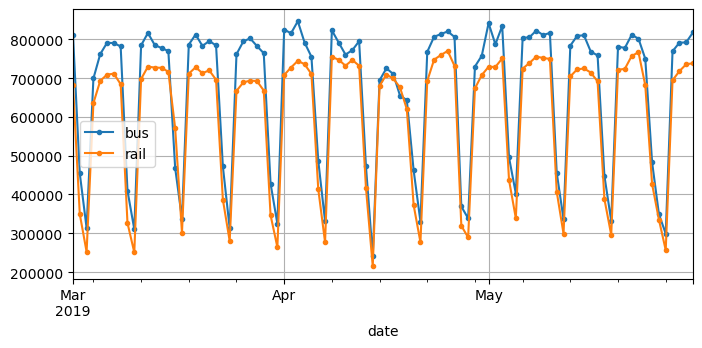

In [16]:
import matplotlib.pyplot as plt

df['2019-03':'2019-05'].plot(grid=True, marker='.', figsize=(8, 3.5))
plt.show()

Note that Pandas includes both the start and end month in the range, so this plots the data from the 1st of March all the way up to the 31st of May. This is a *time series*: data with values at different time steps, usually at regular intervals. More specifically, since there are multiple values per time step, this is called a *multivariate time series*. If we only looked at the bus column, it would be a *univariate time series*, with a single value per time step. Predicting future values (i.e., forecasting) is the most typical task when dealing with time series, and this is what we will focus on in this chapter. Other tasks include imputation (filling in missing past values), classification, anomaly detection, and more.

Looking at [Graph](#plot1) plotted above, we can see that a similar pattern is clearly repeated every week. This is called a weekly *seasonality*. In fact, it’s so strong in this case that forecasting tomorrow’s ridership by just copying the values from a week earlier will yield reasonably good results. This is called *naive forecasting*: simply copying a past value to make our forecast. Naive forecasting is often a great baseline, and it can even be tricky to beat in some cases.

> #### **NOTE**
> In general, naive forecasting means copying the latest known value (e.g., forecasting that tomorrow will be the same as today). However, in our case, copying the value from the previous week works better, due to the strong weekly seasonality.



To visualize these naive forecasts, let’s overlay the two time series (for bus and rail) as well as the same time series lagged by one week (i.e., shifted toward the right) using dotted lines. We’ll also plot the difference between the two (i.e., the value at time t minus the value at time *t – 7*); this is called *differencing* (see [Graph](#plot2) below):
<span id=plot2></span>

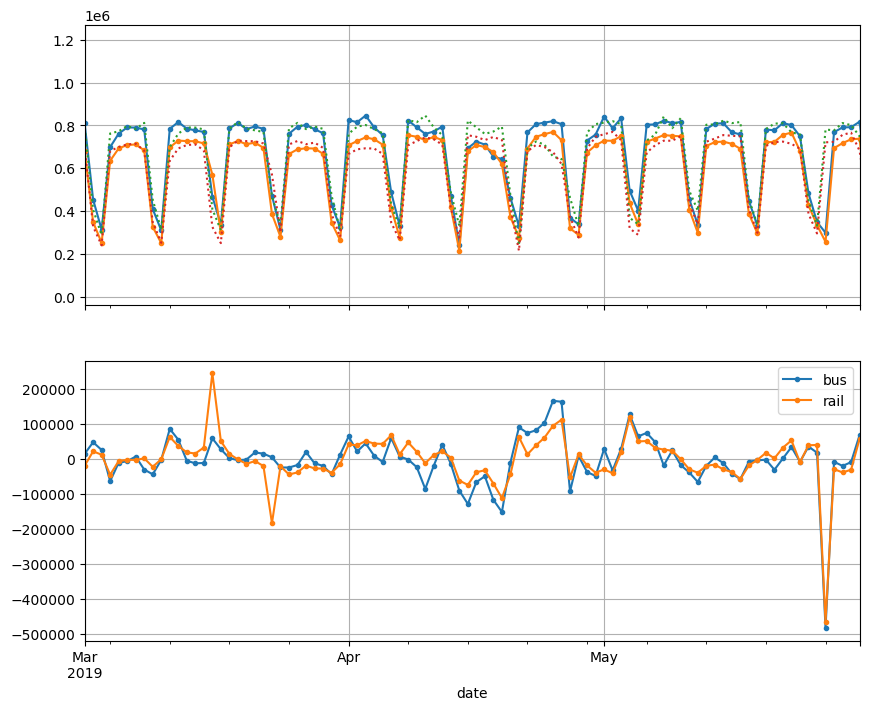

In [17]:
diff_7 = df[['bus', 'rail']].diff(7)['2019-03':'2019-05']

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
df.plot(ax=axs[0], legend=False, marker='.') # Original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=':') # lagged
diff_7.plot(ax=axs[1], grid=True, marker='.') # 7-day difference time series
plt.show()

Not too bad! Notice how closely the lagged time series track the actual time series. When a time series is correlated with a lagged version of itself, we say that the time series is *autocorrelated*. As you can see, most of the differences are fairly small, except at the end of May. Maybe there was a holiday at that time? Let’s check the ***day_type*** column:

In [18]:
list(df.loc['2019-05-25':'2019-05-27']['day_type'])

['A', 'U', 'U']

Indeed, there was a long weekend back then: the Monday was the Memorial Day holiday. We could use this column to improve our forecasts, but for now let’s just measure the mean absolute error over the three-month period we’re arbitrarily focusing on—March, April, and May 2019—to get a rough idea:

In [19]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Our naive forecasts get an MAE of about 43,916 bus riders, and about 42,143 rail riders. It’s hard to tell at a glance how good or bad this is, so let’s put the forecast errors into perspective by dividing them by the target values:

In [20]:
targets = df[['bus', 'rail']]['2019-03':'2019-05']
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64


What we just computed is called the *mean absolute percentage error* (**MAPE**): it looks like our naive forecasts give us a **MAPE** of roughly 8.3% for bus and 9.0% for rail. It’s interesting to note that the **MAE** for the rail forecasts looks slightly better than the **MAE** for the bus forecasts, while the opposite is true for the **MAPE**. That’s because the bus ridership is larger than the rail ridership, so naturally the forecast errors are also larger, but when we put the errors into perspective, it turns out that the bus forecasts are actually slightly better than the rail forecasts.

> #### **TIP**
> The **MAE**, **MAPE**, and **MSE** are among the most common metrics you can use to evaluate your forecasts. As always, choosing the right metric depends on the task. For example, if your project suffers quadratically more from large errors than from small ones, then the **MSE** may be preferable, as it strongly penalizes large errors.

Looking at the time series, there doesn’t appear to be any significant monthly seasonality, but let’s check whether there’s any yearly seasonality. We’ll look at the data from 2001 to 2019. To reduce the risk of data snooping, we’ll ignore more recent data for now. Let’s also plot a 12-month rolling average for each series to visualize long-term trends (see [Graph](#plot3) below):
<span id=plot3></span>

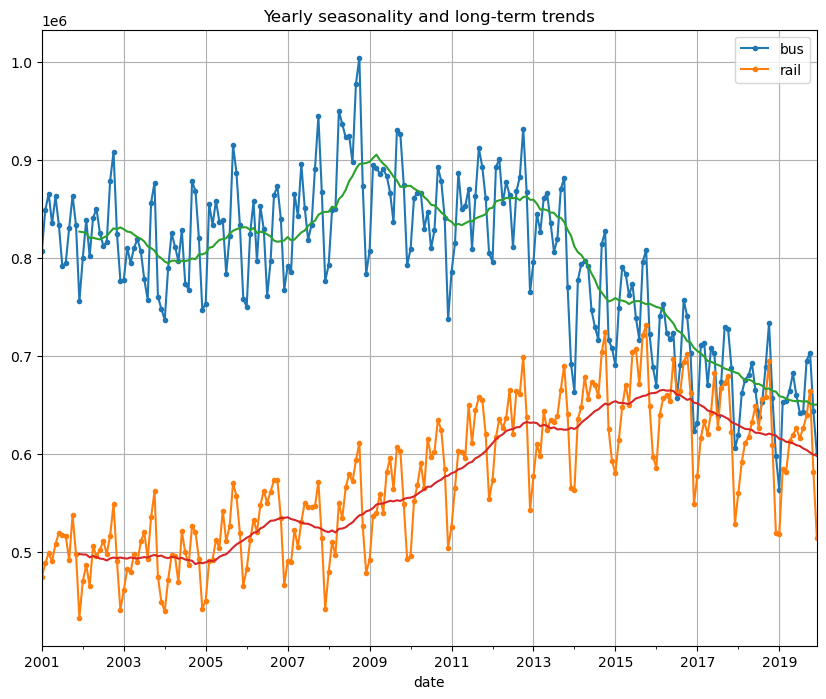

In [21]:
period = slice('2001', '2019')
df_monthly = df.select_dtypes(include='number').resample('ME').mean() # compute the mean for each month.
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(10, 8))
df_monthly[period].plot(ax=ax, marker='.')

rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.title("Yearly seasonality and long-term trends")
plt.show()

Yep! There’s definitely some yearly seasonality as well, although it is noisier than the weekly seasonality, and more visible for the rail series than the bus series: we see peaks and troughs at roughly the same dates each year. Let’s check what we get if we plot the 12-month difference (see [Graph](#plot4) below):
<span id=plot4></span>

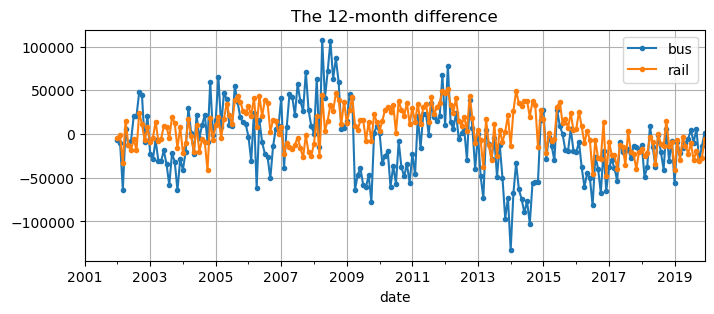

In [22]:
df_monthly.diff(12)[period].plot(grid=True, marker='.', figsize=(8, 3))
plt.title("The 12-month difference")
plt.show()

Notice how differencing not only removed the yearly seasonality, but it also removed the long-term trends. For example, the linear downward trend present in the time series from 2016 to 2019 became a roughly constant negative value in the differenced time series. In fact, differencing is a common technique used to remove trend and seasonality from a time series: it’s easier to study a *stationary* time series, meaning one whose statistical properties remain constant over time, without any seasonality or trends. Once you’re able to make accurate forecasts on the differenced time series, it’s easy to turn them into forecasts for the actual time series by just adding back the past values that were previously subtracted.

You may be thinking that we’re only trying to predict tomorrow’s ridership, so the long-term patterns matter much less than the short-term ones. You’re right, but still, we may be able to improve performance slightly by taking long-term patterns into account. For example, daily bus ridership dropped by about 2,500 in October 2017, which represents about 570 fewer passengers each week, so if we were at the end of October 2017, it would make sense to forecast tomorrow’s ridership by copying the value from last week, minus 570. Accounting for the trend will make your forecasts a bit more accurate on average.

Now that you’re familiar with the ridership time series, as well as some of the most important concepts in time series analysis, including seasonality, trend, differencing, and moving averages, let’s take a quick look at a very popular family of statistical models that are commonly used to analyze time series.

### **The ARMA Model Family**
We’ll start with the *autoregressive moving average* (**ARMA**) model, developed by Herman Wold in the 1930s: it computes its forecasts using a simple weighted sum of lagged values and corrects these forecasts by adding a moving average, very much like we just discussed. Specifically, the moving average component is computed using a weighted sum of the last few forecast errors. [Equation 15-3](#eqn153) shows how the model makes its forecasts.

<span id=eqn153>![Forecasting using an ARAM model](e153.png)</span>

In this equation:
- *ŷ<sub>(t)</sub>* is the model's forecast for time step *t*.

- *y<sub>(t)</sub>* is the time series' value at time step *t*.

- The first sum is the weighted sum of the past *p* values of the time series, using the learned weights *α<sub>i</sub>* . The number *p* is a hyperparameter, and it determines how far back into the past the model should look. This sum is the *autoregressive* component of the model: it performs regression based on past values.

- The second sum is the weighted sum over the past *q* forecast errors *ε<sub>(t)</sub>*, using the learned weights *θ<sub>i</sub>* . The number *q* is a hyperparameter. This sum is the moving average component of the model.

Importantly, this model assumes that the time series is stationary. If it is not, then differencing may help. Using differencing over a single time step will produce an approximation of the derivative of the time series: indeed, it will give the slope of the series at each time step. This means that it will eliminate any linear trend, transforming it into a constant value. For example, if you apply one-step differencing to the series [3, 5, 7, 9, 11], you get the differenced series [2, 2, 2, 2].

If the original time series has a quadratic trend instead of a linear trend, then a single round of differencing will not be enough. For example, the series [1, 4, 9, 16, 25, 36] becomes [3, 5, 7, 9, 11] after one round of differencing, but if you run differencing for a second round, then you get [2, 2, 2, 2]. So, running two rounds of differencing will eliminate quadratic trends. More generally, running *d* consecutive rounds of differencing computes an approximation of the *<sup>th</sup>d* order derivative of the time series, so it will eliminate polynomial trends up to degree *d*. This hyperparameter d is called the *order of integration*.

Differencing is the central contribution of the *autoregressive integrated moving average* (**ARIMA**) model, introduced in 1970 by George Box and Gwilym Jenkins in their book *Time Series Analysis* (**Wiley**): this model runs d rounds of differencing to make the time series more stationary, then it applies a regular **ARMA** model. When making forecasts, it uses this **ARMA** model, then it adds back the terms that were subtracted by differencing.

One last member of the **ARMA** family is the *seasonal* ***ARIMA*** (**SARIMA**) model: it models the time series in the same way as **ARIMA**, but it additionally models a seasonal component for a given frequency (e.g., weekly), using the exact same **ARIMA** approach. It has a total of seven hyperparameters: the same *p*, *d*, and *q* hyperparameters as **ARIMA**, plus additional ***P***, ***D***, and ***Q*** hyperparameters to model the seasonal pattern, and lastly the period of the seasonal pattern, noted *s*. The hyperparameters ***P***, ***D***, and ***Q*** are just like *p*, *d*, and *q*, but they are used to model the time series at *t – s*, *t – 2s*, *t – 3s*, etc.

Let’s see how to fit a **SARIMA** model to the rail time series, and use it to make a forecast for tomorrow’s ridership. We’ll pretend today is the last day of May 2019, and we want to forecast the rail ridership for “tomorrow”, the 1st of June, 2019. For this, we can use the ***statsmodels*** library, which contains many different statistical models, including the **ARMA** model and its variants, implemented by the ***ARIMA*** class:

In [23]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = '2019-01-01', '2019-05-31'
rail_series = df.loc[origin:today]['rail'].asfreq('D')
model = ARIMA(
    rail_series, 
    order=(1, 0, 0), 
    seasonal_order=(0, 1, 1, 7)
    )
model = model.fit()
y_pred = model.forecast() 
y_pred # Returns 427758.62643

2019-06-01    427758.62643
Freq: D, dtype: float64

In this code example:
- We start by importing the ***ARIMA*** class, then we take the rail ridership data from the start of 2019 up to "today", and we use ***asfred("D")*** to set the time series’ frequency to daily: this doesn’t change the data at all in this case, since it’s already daily, but without this the **ARIMA** class would have to guess the frequency, and it would display a warning.

- Next, we create an ***ARIMA*** instance, passing it all the data until “today”, and we set the model hyperparameters: ***order=(1, 0, 0)*** means that *p* = 1, *d* = 0, *q* = 0, and ***seasonal_order=(0, 1, 1, 7)*** means that **P** = 0, **D** = 1, **Q** = 1, and **s** = 7. Notice that the ***statsmodels*** **API** differs a bit from Scikit-Learn’s **API**, since we pass the data to the model at construction time, instead of passing it to the ***fit()*** method.

- Next, we fit the model, and we use it to make a forecast for "tommorow", the last 1st of June, 2019.

The forecast is 427,759 passengers, when in fact there were 379,044. Yikes, we’re 12.9% off—that’s pretty bad. It’s actually slightly worse than naive forecasting, which forecasts 426,932, off by 12.6%. But perhaps we were just unlucky that day? To check this, we can run the same code in a loop to make forecasts for every day in March, April, and May, and compute the MAE over that period:

In [24]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"

time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]['rail'].asfreq("D")
y_preds = []

for today in time_period.shift(-1):
    model = ARIMA(
        rail_series[origin:today], # train on data up to "today"
        order=(1, 0, 0), 
        seasonal_order=(0, 1, 1, 7)
        )
    model = model.fit() # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean() # returns 32040.720091253406

C:\Users\jacks\AppData\Local\Temp\ipykernel_21180\2220318574.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\jacks\AppData\Local\Temp\ipykernel_21180\2220318574.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\jacks\AppData\Local\Temp\ipykernel_21180\2220318574.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\User

Ah, that’s much better! The **MAE** is about 32,041, which is significantly lower than the **MAE** we got with naive forecasting (42,143). So although the model is not perfect, it still beats naive forecasting by a large margin, on average.

At this point, you may be wondering how to pick good hyperparameters for the **SARIMA** model. There are several methods, but the simplest to understand and to get started with is the brute-force approach: just run a grid search. For each model you want to evaluate (i.e., each hyperparameter combination), you can run the preceding code example, changing only the hyperparameter values. Good *p*, *q*, *P*, and *Q* values are usually fairly small (typically 0 to 2, sometimes up to 5 or 6), and *d* and *D* are typically 0 or 1, sometimes 2. As for *s*, it’s just the main seasonal pattern’s period: in our case it’s 7 since there’s a strong weekly seasonality. The model with the lowest **MAE** wins. Of course, you can replace the **MAE** with another metric if it better matches your business objective. And that’s it!

### **Prepare the Data for Machine Learning Models**
Now that we have two baselines, naive forecasting and SARIMA, let’s try to use the machine learning models we’ve covered so far to forecast this time series, starting with a basic linear model. Our goal will be to forecast tomorrow’s ridership based on the ridership of the past 8 weeks of data (56 days). The inputs to our model will therefore be sequences (usually a single sequence per day once the model is in production), each containing 56 values from time steps t – 55 to t. For each input sequence, the model will output a single value: the forecast for time step t + 1.

But what will we use as training data? Well, that’s the trick: we will use every 56-day window from the past as training data, and the target for each window will be the value immediately following it.

Keras actually has a nice utility function called ***tf.keras.utils.timeseries_ data set_from_array()*** tohelp us prepare the training set. It takes a time series as input, and it builds a tf.data.Dataset (introduced in Chapter 13) containing all the windows of the desired length, as well as their corresponding targets. Here’s an example that takes a time series containing the numbers 0 to 5 and creates a dataset containing all the windows of length 3, with their corresponding targets, grouped into batches of size 2:

In [25]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series, 
    targets=my_series[3:], # the targets are 3 steps into the future
    sequence_length=3, 
    batch_size=2
)

Let's inspect the contents of this dataset:

In [26]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

Each sample in the dataset is a window of length 3, along with its corresponding target (i.e., the value immediately after the window). The windows are [0, 1, 2], [1, 2, 3], and [2, 3, 4], and their respective targets are 3, 4, and 5. Since there are three windows in total, which is not a multiple of the batch size, the last batch only contains one window instead of two.

Another way to get the same result is to use the ***window()*** method of tf.data’s ***Dataset*** class. It’s more complex, but it gives you full control,which will come in handy later in this chapter, so let’s see how it works. The ***window()*** method returns a dataset of window datasets:

In [27]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In this example, the dataset contains six windows, each shifted by one step compared to the previous one, and the last three windows are smaller because they’ve reached the end of the series. In general you’ll want to get rid of these smaller windows by passing ***drop_remainder=True*** to the ***window()*** method.

The ***window()*** method returns a *nested dataset*, analogous to a list of lists. This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them). However, we cannot use a nested dataset directly for training, as our model will expect tensors as input, not datasets.

Therefore, we must call the ***flat_map()*** method: it converts a nested dataset into a *flat dataset* (one that contains tensors, not datasets). For example, suppose {1, 2, 3} represents a dataset containing the sequence of tensors 1, 2, and 3. If you flatten the nested dataset {{1, 2}, {3, 4, 5, 6}}, you get back the flat dataset {1, 2, 3, 4, 5, 6}.

Moreover, the ***flat_map()*** method takes a function as an argument, which allows you to transform each dataset in the nested dataset before flattening. For example, if you pass the function ***lambda ds***: ***ds.batch(2)*** to ***flat_map()***, then it will transform the nested dataset{{1, 2}, {3, 4, 5, 6}} into the flat dataset {[1, 2], [3, 4], [5, 6]}: it’s a dataset containing 3 tensors, each of size 2.

With that in mind, we are ready to flatten our dataset:

In [28]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset:window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


Since each window dataset contains exactly four items, calling ***batch(4)*** on a window produces a single tensor of size 4. Great! We now have a dataset containing consecutive windows represented as tensors. Let’s create a little helper function to make it easier to extract windows from a dataset:

In [29]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

The last step is to split each window into inputs and targets, using the ***map()*** method we can also group the resulting windows into batches of size 2:

In [30]:
dataset = to_windows(tf.data.Dataset.range(6), 4) # 3 inputs + 1 target
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

As you can see, we now have the same output as we got earlier with the ***timeseries_dataset_from_array()*** function (with a bit more effort, but it will be worthwhile soon).

Now, before we start training, we need to split our data into a training period, a validation period, and a test period. We will focus on the rail ridership for now. We will also scale it down by a factor of one million, to ensure the values are near the 0–1 range; this plays nicely with the default weight initialization and learning rate:

In [31]:
rail_train = df['rail']['2016-01':'2018-12'] / 1e6
rail_valid = df['rail']['2019-01':'2019-05'] / 1e6
rail_test = df['rail']['2019-06': ] / 1e6

> #### **NOTE**
>  When dealing with time series, you generally want to split across time. However, in some cases you may be able to split along other dimensions, which will give you a longer time period to train on. For example, if you have data about the financial health of 10,000 companies from 2001 to 2019, you might be able to split this data across the different companies. It’s very likely that many of these companies will be strongly correlated, though (e.g., whole economic sectors may go up or down jointly), and if you have correlated companies across the training set and the test set, your test set will not be as useful, as its measure of the generalization error will be optimistically biased.

Next, let’s use ***timeseries_dataset_from_array()*** to create datasets for training and validation. Since gradient descent expects the instances in the training set to be independent and identically distributed (**IID**), as we saw in Chapter 4, we must set the argument ***shuffle=True*** to shuffle the training windows (but not their contents):

In [32]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(), 
    targets=rail_train[seq_length:], 
    sequence_length=seq_length, 
    shuffle=True,
    seed=50
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(), 
    targets=rail_valid[seq_length:], 
    sequence_length=seq_length, 
    batch_size=32
)

test_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_test.to_numpy(), 
    targets=rail_test[seq_length:], 
    sequence_length=seq_length, 
)

And now we're ready to build and train any regression model we want!

### **Forecasting Using a Linear Model**
Let’s try a basic linear model first. We will use the Huber loss, which usually works better than minimizing the **MAE** directly, as discussed in Chapter 10. We’ll also use early stopping:

In [33]:
tf.random.set_seed(50)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=50, restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])

history = model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=500, 
    callbacks=[early_stopping_cb])

Epoch 1/500


d:\CONTENTS\APPLICATIONS\New Folder\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.5156 - mae: 0.9406 - val_loss: 0.3869 - val_mae: 0.8315
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2291 - mae: 0.5925 - val_loss: 0.1647 - val_mae: 0.5377
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0930 - mae: 0.3677 - val_loss: 0.0660 - val_mae: 0.3302
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0381 - mae: 0.2342 - val_loss: 0.0292 - val_mae: 0.2045
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0204 - mae: 0.1620 - val_loss: 0.0174 - val_mae: 0.1501
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0150 - mae: 0.1365 - val_loss: 0.0095 - val_mae: 0.1056
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0118 - mae: 0.1149 - val_loss: 0.0075 - val_mae: 0.0946
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0096 - mae: 0.1017 - val_loss: 0.0074 - val_mae: 0.0939
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0087 - mae: 0.0943 - val

This model reaches a validation **MAE** of about 37,866 (your mileage may vary). That’s better than naive forecasting, but worse than the **SARIMA** model.

Can we do better with an RNN? Let's see!

### **Forecasting Using a Simple RNN**
Let’s try the most basic RNN, containing a single recurrent layer with just one recurrent neuron, as we saw in [Figure 15-1](#fig151):

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

d:\CONTENTS\APPLICATIONS\New Folder\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


All recurrent layers in Keras expect 3D inputs of shape [*batch size*, *time steps*, *dimensionality*], where *dimensionality* is 1 for univariate time series and more for multivariate time series. Recall that the ***input_shape*** argument ignores the first dimension (i.e., the batch size), and since recurrent layers can accept input sequences of any length, we can set the second dimension to ***None***, which means “any size”. Lastly, since we’re dealing with a univariate time series, we need the last dimension’s size to be 1. This is why we specified the input shape [***None***, ***1***]: it means “univariate sequences of any length”. Note that the datasets actually contain inputs of shape [*batch size*, *time steps*], so we’re missing the last dimension, of size 1, but Keras is kind enough to add it for us in this case.

This model works exactly as we saw earlier: the initial state *h<sub>(init)</sub>* is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step, *x<sub>(0)</sub>* . The neuron computes a weighted sum of these values plus the bias term, and it applies the activation function to the result, using the hyperbolic tangent function by default. The result is the first output, *y<sub>0</sub>* . In a simple RNN, this output is also the new state *h<sub>0</sub>* . This new state is passed to the same recurrent neuron along with the next input value, *x<sub>(1)</sub>* , and the process is repeated until the last time step. At the end, the layer just outputs the last value: in our case the sequences are 56 steps long, so the last value is *y<sub>55</sub>* . All of this is performed simultaneously for every sequence in the batch, of which there are 32 in this case.

> #### **NOTE**
> By default, recurrent layers in Keras only return the final output. To make them return one output per time step, you must set ***return_sequences=True***, as you will see.

So that’s our first recurrent model! It’s a sequence-to-vector model. Since there’s a single output neuron, the output vector has a size of 1.



Now if you compile, train, and evaluate this model just like the previous model, you will find that it’s no good at all: its validation **MAE** is greater than 100,000! Ouch. That was to be expected, for two reasons:
1. The model only has a single recurrent neuron, so the only data it can use to make a prediction at each time step is the input value at the current time step and the output value from the previous time step. That’s not much to go on! In other words, the RNN’s memory is extremely limited: it’s just a single number, its previous output. And let’s count how many parameters this model has: since there’s just one recurrent neuron with only two input values, the whole model only has three parameters (two weights plus a bias term). That’s far from enough for this time series. In contrast, our previous model could look at all 56 previous values at once, and it had a total of 57 parameters.

2. The time series contains values from 0 to about 1.4, but since the default activation function is tanh, the recurrent layer can only output values between –1 and +1. There’s no way it can predict values between 1.0 and 1.4.

Let’s fix both of these issues: we will create a model with a larger recurrent layer, containing 32 recurrent neurons, and we will add a dense output layer on top of it with a single output neuron and no activation function. The recurrent layer will be able to carry much more information from one time step to the next, and the dense output layer will project the final output from 32 dimensions down to 1, without any value range constraints:

In [35]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape={None, 1}), 
    tf.keras.layers.Dense(1) # No activation function by default
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=50, restore_best_weights=True
)
univar_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
hist = univar_model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0132 - mae: 0.1297 - val_loss: 0.0122 - val_mae: 0.1115
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 969ms/step - loss: 0.0104 - mae: 0.1166 - val_loss: 0.0079 - val_mae: 0.0947
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0067 - mae: 0.0885 - val_loss: 0.0049 - val_mae: 0.0814
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0053 - mae: 0.0751 - val_loss: 0.0038 - val_mae: 0.0713
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0050 - mae: 0.0689 - val_loss: 0.0030 - val_mae: 0.0584
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 630ms/step - loss: 0.0041 - mae: 0.0613 - val_loss: 0.0029 - val_mae: 0.0540
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step - loss: 0.0039 - mae: 0.0574 - val_loss: 0.0024 - val_mae: 0.0489
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 629ms/step - loss: 0.0036 - mae: 0.0562 - val_loss: 0.0032 - val_mae: 0.0574
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 935ms/step - loss: 0.0037 - mae: 0.0583 - val_

KeyboardInterrupt: 

Now if you compile, fit, and evaluate this model just like the previous one, you will find that its validation MAE reaches 27,703. That’s the best model we’ve trained so far, and it even beats the **SARIMA** model: we’re doing pretty well!

> #### **TIP**
> We’ve only normalized the time series, without removing trend and seasonality, and yet the model still performs well. This is convenient, as it makes it possible to quickly search for promising models without worrying too much about preprocessing. However, to get the best performance, you may want to try making the time series more stationary; for example, using differencing.

### **Forecast Using a Deep RNN**
It is quite common to stack multiple layers of cells, as shown in [Figure 15-10](#fig1510). This gives you a *deep RNN*.

<span id='fig1510'></span>
![A deep RNN (left) unrolled through time (right)](f1510.png)

Implementing a deep RNN with Keras is straightforward: just stack recurrent layers. In the following example, we use three ***SimpleRNN*** layers (but we could use any other type of recurrent layer instead, such as an **LSTM** layer or a **GRU** layer, which we will discuss shortly). The first two are sequence-to-sequence layers, and the last one is a sequence-to-vector layer. Finally, the ***Dense*** layer produces the model’s forecast (you can think of it as a vector-to-vector layer). So this model is just like the model represented in [Figure 15-10](#fig1510), except the outputs **Ŷ**<sub>(0)</sub> to *Ŷ**<sub>(t-1_)</sub> are ignored, and there’s a dense layer on top of **Ŷ**<sub>(t)</sub> , which outputs the actual forecast:

In [ ]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]), 
    tf.keras.layers.SimpleRNN(32, return_sequences=True), 
    tf.keras.layers.SimpleRNN(32), 
    tf.keras.layers.Dense(1)
])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
deep_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

simp_deep_hist = deep_model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=500, 
    callbacks=[early_stop]
)

Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0656 - mae: 0.2759 - val_loss: 0.0149 - val_mae: 0.1478
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0112 - mae: 0.1205 - val_loss: 0.0052 - val_mae: 0.0823
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0074 - mae: 0.0933 - val_loss: 0.0029 - val_mae: 0.0544
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0047 - mae: 0.0652 - val_loss: 0.0029 - val_mae: 0.0518
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0043 - mae: 0.0606 - val_loss: 0.0022 - val_mae: 0.0413
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0040 - mae: 0.0586 - val_loss: 0.0023 - val_mae: 0.0441
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0046 - mae: 0.0597 - val_loss: 0.0026 - val_mae: 0.0480
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0039 - mae: 0.0567 - val_loss: 0.0021 - val_mae: 0.0379
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0036 - mae: 

In [ ]:
prediction = deep_model.evaluate(test_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0090 - mae: 0.1153


> #### **WARNING**
> Make sure to set ***return_sequences=True*** for all recurrent layers (except the last one, if you only care about the last output). If you forget to set this parameter for one recurrent layer, it will output a 2D array containing only the output of the last time tep, instead of a 3D array containing outputs for all time steps. The next recurrent layer will complain that you are not feeding it sequences in the expected 3D format.

If you train and evaluate this model, you will find that it reaches an **MAE** of about 31,211. That’s better than both baselines, but it doesn’t beat our “shallower” RNN. It looks like this **RNN** is a bit too large for our task.

### **Forecasting Multivariate Time Series**
A great quality of neural networks is their flexibility: in particular, they can deal with multivariate time series with almost no change to their architecture. For example, let’s try to forecast the rail time series using both the bus and rail data as input. In fact, let’s also throw in the day type! Since we can always know in advance whether tomorrow is going to be a weekday, a weekend, or a holiday, we can shift the day type series one day into the future, so that the model is given tomorrow’s day type as input. For simplicity, we’ll do this processing using Pandas:

In [36]:
df_mulvar = df[['bus', 'rail']] / 1e6 # Use noth bus & rail series as input
df_mulvar['next_day_type'] = df['day_type'].shift(-1) # We know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar) # one-hot encode the day type

Now ***df_mulvar*** is a DataFrame with five columns: the bus and rail data, plus three columns containing the one-hot encoding of the next day’s type (recall that there are three possible day types, ***W***, ***A***, and ***U***). Next we can proceed much like we did earlier. First we split the data into three periods, for training, validation, and testing:

In [37]:
mulvar_train = df_mulvar['2016-01':'2018-12']
mulvar_valid = df_mulvar['2019-01':'2019-05']
mulvar_test = df_mulvar['2019-06':]

Then we create the datasets:

In [38]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(), 
    targets=rail_train[seq_length:], 
    sequence_length=seq_length, 
    shuffle=True,
    seed=50
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(), 
    targets=rail_valid[seq_length:], 
    sequence_length=seq_length, 
    batch_size=32
)

test_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_test.to_numpy(), 
    targets=rail_test[seq_length:], 
    sequence_length=seq_length, 
)

In [39]:
seq_length=56
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(dtype=float), # use all 5 columns as input
    targets=mulvar_train['rail'].to_numpy(dtype=float)[seq_length:], # Forecast only the rail series
    sequence_length=seq_length, 
    shuffle=True, 
    seed=50
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(dtype=float), 
    targets=mulvar_valid['rail'].to_numpy(dtype=float)[seq_length:], 
    sequence_length=seq_length, 
    batch_size=32
)

test_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_test.to_numpy(dtype=float), 
    targets=mulvar_train['rail'].to_numpy(dtype=float)[seq_length:], 
    sequence_length=seq_length, 
    )

And finally we create the RNN:

In [ ]:
tf.config.run_functions_eagerly(True)

mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]), 
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam()
mulvar_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
mulvar_hist = mulvar_model.fit(
    train_mulvar_ds, 
    validation_data=valid_mulvar_ds, 
    epochs=500, 
    callbacks=[early_stop]
)

Epoch 1/500


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.2913 - mae: 0.6734 - val_loss: 0.0812 - val_mae: 0.3266
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 813ms/step - loss: 0.0850 - mae: 0.3238 - val_loss: 0.0788 - val_mae: 0.2985
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 850ms/step - loss: 0.0685 - mae: 0.2732 - val_loss: 0.0358 - val_mae: 0.2039
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 894ms/step - loss: 0.0363 - mae: 0.2168 - val_loss: 0.0228 - val_mae: 0.1700
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 761ms/step - loss: 0.0244 - mae: 0.1721 - val_loss: 0.0136 - val_mae: 0.1123
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.0177 - mae: 0.1247 - val_loss: 0.0098 - val_mae: 0.0863
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 784ms/step - loss: 0.0114 - mae: 0.0930 - val_loss: 0.0067 - val_mae: 0.0617
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 863ms/step - loss: 0.0096 - mae: 0.0732 - val_loss: 0.0055 - val_mae: 0.0515
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 885ms/step - loss: 0.0086 - mae: 0.0683 

In [ ]:
mulvar_model.evaluate(test_mulvar_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - loss: 0.1016 - mae: 0.3656


[0.12050050497055054, 0.4240165054798126]

Notice that the only difference from the ***univar_model*** RNN we built earlier is the input shape: at each time step, the model now receives five inputs instead of one. This model actually reaches a validation MAE of 22,062. Now we’re making big progress!

In fact, it’s not too hard to make the RNN forecast both the bus and rail ridership. You just need to change the targets when creating the datasets, setting them to ***mulvar_train[["bus", "rail"]] [seq_length:]*** for the training set, and ***mulvar_valid[["bus", "rail"]][seq_length:]*** for the validation set. You must also add an extra neuron in the output ***Dense*** layer, since it must now make two forecasts: one for tomorrow’s bus ridership, and the other for rail. That’s all there is to it!

As we discussed in Chapter 10, using a single model for multiple related tasks often results in better performance than using a separate model for each task, since features learned for one task may be useful for the other tasks, and also because having to perform well across multiple tasks prevents the model from overfitting (it’s a form of regularization). However, it depends on the task, and in this particular case the multitask RNN that forecasts both the bus and the rail ridership doesn’t perform quite as well as dedicated models that forecast one or the other (using all five columns as input). Still, it reaches a validation MAE of 25,330 for rail and 26,369 for bus, which is pretty good.

### **Forecast Several Time Steps Ahead**
So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict the ridership 2 weeks from now, we could just change the targets to be the value 14 days ahead instead of 1 day ahead). But what if we want to predict the next 14 values?

The first option is to take the ***univar_model*** RNN we trained earlier for the rail time series, make it predict the next value, and add that value to the inputs, acting as if the predicted value had actually occurred; we would then use the model again to predict the following value, and so on, as in the following code:

d:\CONTENTS\APPLICATIONS\New Folder\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


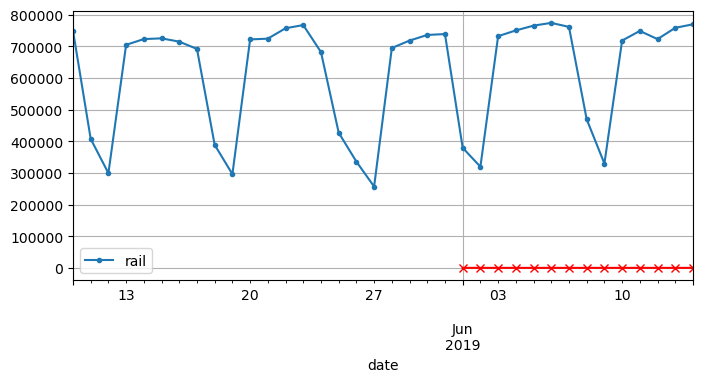

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppose rail_valid and deep_model are already defined
df_ = df[['rail']]

# Prepare input x
x = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
predictions = []

for step_ahead in range(14):
    y_pred_one = univar_model.predict(x)
    predictions.append(y_pred_one.flatten()[0])
    x = np.concatenate([x, y_pred_one.reshape(1, 1, 1)], axis=1)

# Create prediction series
date_range = pd.date_range(start='2019-06', periods=14, freq='D')
pred_series = pd.Series(predictions, index=date_range)

# Plot actual data
df_['2019-05-10':'2019-06-14'].plot(grid=True, marker='.', figsize=(8, 3.5))

# Plot predictions
pred_series.plot(grid=True, marker='x', color='red')

plt.show()

In this code, we take the rail ridership of the first 56 days of the validation period, and we convert the data to a NumPy array of shape [1, 56, 1] (recall that recurrent layers expect 3D inputs). Then we repeatedly use the model to forecast the next value, and we append each forecast to the input series,along the time axis (***axis=1***). The resulting forecasts are plotted in [Figure 15-11](#fig1511).

<span id=fig1511></span>
![Forecasting 14 steps ahead, 1 step at a time](f1511.png)

The second option is to train an RNN to predict the next 14 values in one shot. We can still use a sequence-to-vector model, but it will output 14 values instead of 1. However, we first need to change the targets to be vectors containing the next 14 values. To do this, we can use ***timeseries_dataset_from_array()*** again, but this time asking it to create datasets without targets (***targets=None***) and with longer sequences, of length ***seq_length*** + 14. Then we can use the datasets’ ***map()*** method to apply a custom function to each batch of sequences, splitting them into inputs and targets. In this example, we use the multivariate time series as input (using all five columns), and we forecast the rail ridership for the next 14 days:

In [40]:
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(dtype=float), 
    targets=None, 
    sequence_length=seq_length + 14, 
    shuffle=True, 
    seed=50, 
    ).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(dtype=float), 
    targets=None, 
    sequence_length=seq_length + 14, 
    batch_size=32
    ).map(split_inputs_and_targets)

Now we just need the output layer to have 14units instead of 1:

In [41]:
ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]), 
    tf.keras.layers.Dense(14)
])

d:\CONTENTS\APPLICATIONS\New Folder\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True)
ahead_model.compile(optimizer=sgd_optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
ahead_model.fit(
    ahead_train_ds, 
    validation_data=ahead_valid_ds, 
    epochs=500, 
    callbacks=[early_stop]
)

Epoch 1/500


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 881ms/step - loss: 0.0092 - mae: 0.1043 - val_loss: 0.0073 - val_mae: 0.0907
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 796ms/step - loss: 0.0088 - mae: 0.1003 - val_loss: 0.0069 - val_mae: 0.0892
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 932ms/step - loss: 0.0086 - mae: 0.1014 - val_loss: 0.0067 - val_mae: 0.0881
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 516ms/step - loss: 0.0085 - mae: 0.0985 - val_loss: 0.0067 - val_mae: 0.0865
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 559ms/step - loss: 0.0083 - mae: 0.0977 - val_loss: 0.0066 - val_mae: 0.0861
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 630ms/step - loss: 0.0080 - mae: 0.0957 - val_loss: 0.0063 - val_mae: 0.0841
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 880ms/step - loss: 0.0082 - mae: 0.0975 - val_loss: 0.0059 - val_mae: 0.0833
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0080 - mae: 0.0968 - val_loss: 0.0059 - val_mae: 0.0821
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 934ms/step - loss: 0.0080 - mae: 0.0953

After training this model you can predict the next 14 values at once like this:

In [ ]:
x = mulvar_valid.to_numpy(dtype=float)[np.newaxis, :seq_length] # shape [1, 56, 5]
y_pred = ahead_model.predict(x) # shape [1, 14]
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


array([[0.7007666 , 0.68769616, 0.7339628 , 0.69159985, 0.35074162,
        0.27841994, 0.6305888 , 0.6923661 , 0.69494945, 0.70580083,
        0.7248332 , 0.40045393, 0.2657362 , 0.68215317]], dtype=float32)

This approach works quite well. Its forecasts for the next day are obviously better than its forecasts for 14 days into the future, but it doesn’t accumulate errors like the previous approach did. However, we can still do better, using a sequence-to-sequence (or *seq2seq*) model.

### **Forecasting Using a Sequence-to-Sequence Model**
Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step. In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just for the output at the last time step.

This means there will be many more error gradients flowing through the model, and they won’t have to flow through time as much since they will come from the output of each time step, not just the last one. This will both stabilize and speed up training.

To be clear, at time step 0 the model will output a vector containing the forecasts for time steps 1 to 14, then at time step 1 the model will forecast time steps 2 to 15, and so on. In other words, the targets are sequences of consecutive windows, shifted by one time step at each time step. The target is not a vector anymore, but a sequence of the same length as the inputs, containing a 14-dimensional vector at each step.

Preparing the datasets is not trivial, since each instance has a window as input and a sequence of windows as output. One way to do this is to use the ***to_windows()*** utility function we created earlier, twice in a row, to get windows of consecutive windows. For example, let’s turn the series of numbers 0 to 6 into a dataset containing sequences of 4 consecutive windows, each of length 3:

In [42]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

my_series = tf.data.Dataset.range(7)
first_window = to_windows(my_series, 3)
dataset = to_windows(first_window, 4)
output = list(dataset)

for item in output:
    print(item.numpy())

[[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]]
[[1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]]


Now we can use the ***map()*** method to split these windows of windows into inputs and targets:

In [43]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

Now the dataset contains sequences of length 4 as inputs, and the targets are sequences containing the next two steps, for each time step. For example, the first input sequence is [0, 1, 2, 3], and its corresponding targets are [[1, 2], [2, 3], [3, 4], [4, 5]], which are the next two values for each time step. If you’re like me, you will probably need a few minutes to wrap your head around this. Take your time!

> #### **NOTE**
> It may be surprising that the targets contain values that appear in the inputs. Isn’t that cheating? Fortunately, not at all: at each time step, an RNN only knows about past time steps; it cannot look ahead. It is said to be a *causal* model.

Let’s create another little utility function to prepare the datasets for our sequence-to-sequence model. It will also take care of shuffling (optional) and batching:

In [44]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
    series = series.values
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [45]:
def to_seq2seq_dataset(df, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
    # Ensure numeric numpy array
    arr = df.values.astype('float32')  # convert booleans and objects to floats

    # Create windows of size (ahead + 1) over the full multivariate array
    ds = to_windows(tf.data.Dataset.from_tensor_slices(arr), ahead + 1)

    # Then create sliding windows of length seq_length from those, mapping to (input, target)
    ds = to_windows(ds, seq_length).map(
        lambda S: (
            S[:, :-1, :],       # Inputs: all timesteps except last of window
            S[:, 1:, target_col] # Targets: next "ahead" steps for target_col
        )
    )

    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)

    return ds.batch(batch_size)

# Usage
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=50)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

Now we can use this function to create the datasets:

In [46]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=50)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

And lastly, we can build the sequence-to-sequence model:

In [47]:
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]), 
    tf.keras.layers.Dense(14)
])

It is almost identical to our previous model: the only difference is that we set ***return_sequences=True*** in the ***SimpleRNN*** layer. This way, it will output a sequence of vectors (each of size 32), instead of outputting a single vector at the last time step. The ***Dense*** layer is smart enough to handle sequences as input: it will be applied at each time step, taking a 32dimensional vector as input and outputting a 14-dimensional vector. In fact, another way to get the exact same result is to use a ***Conv1D*** layer with a kernel size of 1: ***Conv1D(14, kernel_size=1)***.

> #### **TIP**
> Keras offers a ***TimeDistributed*** layer that lets you apply any vector-to-vector layer to every vector in the input sequences, at every time step. It does this efficiently, by reshaping the inputs so that each time step is treated as a separate instance, then it reshapes the layer’s outputs to recover the time dimension. In our case, we don’t need it since the Dense layer already supports sequences as inputs.

The training code is the same as usual. During training, all the model’s outputs are used, but after training only the output of the very last time step matters, and the rest can be ignored. For example, we can forecast the rail ridership for the next 14 days like this:

In [ ]:
x = mulvar_valid.to_numpy(dtype=float)[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(x)[0, -1] # only the last time step's output
y_pred_14

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


array([-0.13646504,  0.6916928 ,  0.13469797,  0.12968498, -0.1753751 ,
        0.93866897, -0.5323693 ,  0.27868497, -0.28823683, -0.7297761 ,
        0.7993937 ,  1.1945428 ,  0.711866  , -0.50000775], dtype=float32)

If you evaluate this model’s forecasts for t + 1, you will find a validation MAE of 25,519. For t + 2 it’s 26,274, and the performance continues to drop gradually as the model tries to forecast further into the future. At t + 14, the MAE is 34,322.

> #### **TIP**
>  You can combine both approaches to forecasting multiple steps ahead: for example, you can train a model that forecasts 14 days ahead, then take its output and append it to the inputs, then run the model again to get forecasts for the following 14 days, and possibly repeat the process.

Simple RNNs can be quite good at forecasting time series or handling other kinds of sequences, but they do not perform as well on long time series or sequences. Let’s discuss why and see what we can do about it.

## **Handling Long Sequences**
To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the unstable gradients problem, discussed in Chapter 11: it may take forever to train, or training may be unstable. Moreover, when an RNN processes a long sequence, it will gradually forget the first inputs in the sequence. Let’s look at both these problems, starting with the unstable gradients problem.

### **Fighting the Unstable Gradients Problem**
Many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on. However, nonsaturating activation functions (e.g., ReLU) may not help as much here. In fact, they may actually lead the RNN to be even more unstable during training. Why? Well, suppose gradient descent updates the weights in a way that increases the outputs slightly at the first time step. Because the same weights are used at every time step, the outputs at the second time step may also be slightly increased, and those at the third, and so on until the outputs explode—and a nonsaturating activation function does not prevent that.

You can reduce this risk by using a smaller learning rate, or you can use a saturating activation function like the hyperbolic tangent (this explains why it’s the default).

In much the same way, the gradients themselves can explode. If you notice that training is unstable, you may want to monitor the size of the gradients (e.g., using TensorBoard) and perhaps use gradient clipping.

Moreover, batch normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers.

To be more precise, it is technically possible to add a BN layer to a memory cell (as you will see shortly) so that it will be applied at each time step (both on the inputs for that time step and on the hidden state from the previous step). However, the same BN layer will be used at each time step, with the same parameters, regardless of the actual scale and offset of the inputs and hidden state. In practice, this does not yield good results, as was 7 demonstrated by César Laurent et al. in a [2015 paper](https://homl.info/rnnbn):  the authors found that BN was slightly beneficial only when it was applied to the layer’s inputs, not to the hidden states. In other words, it was slightly better than nothing when applied between recurrent layers (i.e., vertically in [Figure 15-10](#fig1510)), but not within recurrent layers (i.e., horizontally). In Keras, you can apply BN between layers simply by adding a ***BatchNormalization*** layer before each recurrent layer, but it will slow down training, and it may not help much.

Another form of normalization often works better with RNNs: ***layer normalization***. This idea was introduced by Jimmy Lei Ba et al. in a [2016 paper](https://homl.info/layernorm):  it is very similar to batch normalization, but instead of normalizing across the batch dimension, layer normalization normalizes across the features dimension. One advantage is that it can compute the required statistics on the fly, at each time step, independently for each instance. This also means that it behaves the same way during training and testing (as opposed to BN), and it does not need to use exponential moving averages to estimate the feature statistics across all instances in the training set, like BN does. Like BN, layer normalization learns a scale and an offset parameter for each input. In an RNN, it is typically used right after the linear combination of the inputs and the hidden states.

Let’s use Keras to implement layer normalization within a simple memory cell. To do this, we need to define a custom memory cell, which is just like a regular layer, except its ***call()*** method takes two arguments: the ***inputs*** at the current time step and the hidden ***states*** from the previous time step.

Note that the ***states*** argument is a list containing one or more tensors. In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors (e.g., an ***LSTMCell*** has a long-term state and a short-term state, as you will see shortly). A cell must also have a ***state_size*** attribute and an ***output_size*** attribute. In a simple RNN, both are simply equal to the number of units. The following code implements a custom memory cell that will behave like a ***SimpleRNNCell***, except it will also apply layer normalization at each time step:

In [ ]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units            
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]
        

Let's walk through this code:
- Our ***LNSimpleRNNCell*** class inherits from the ***tf.keras.layers.Layer*** class, just like any custom layer.

- The constructor takes the number of units and the desired activation function and sets the ***state_size*** and ***output_size*** attributes, then creates a ***SimpleRNNCell*** with no activation function (because we want to perform layer normalization after the linear operation but before the activation function).  Then the constructor creates the ***LayerNormalization*** layer, and finally it fetches the desired activation function.

- The ***call()*** method starts by applying the ***simpleRNNCell***, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice (indeed, in a ***SimpleRNNCell***, the outputs are just equal to the hidden states: in other words, ***new_states[0]*** is equal to ***outputs***, so we can safely ignore ***new_states*** in the rest of the ***call()*** method). Next, the ***call()*** method applies layer normalization, followed by the activation function. Finally, it returns the outputs twice: once as the outputs, and once as the new hidden states. To use this custom cell, all we need to do is create a ***tf.keras.layers.RNN*** layer, passing it a cell instance:

In [48]:
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(
        LNSimpleRNNCell(32), 
        return_sequences=True, 
        input_shape=[None, 5]
        ), 
    tf.keras.layers.Dense(14)
])

d:\CONTENTS\APPLICATIONS\New Folder\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Similarly, you could create a custom cell to apply dropout between each time step. But there’s a simpler way: most recurrent layers and cells provided by Keras have ***dropout*** and ***recurrent_dropout*** hyperparameters: the former defines the dropout rate to apply to the inputs, and the latter defines the dropout rate for the hidden states, between time steps. So, there’s no need to create a custom cell to apply dropout at each time step in an RNN.

With these techniques, you can alleviate the unstable gradients problem and train an RNN much more efficiently. Now let’s look at how to deal with the short-term memory problem.

> #### **TIP**
> When forecasting time series, it is often useful to have some error bars along with your predictions. For this, one approach is to use MC dropout, introduced in Chapter 11: use ***recurrent_dropout*** during training, then keep dropout active at inference time by calling the model using ***model(X, training=True)***. Repeat this several times to get multiple slightly different forecasts, then compute the mean and standard deviation of these predictions for each time step.

### **Tracking the Short-Term Memory Problem**
Due to the transformations that the data goes through when traversing an RNN, some information is lost at each time step. After a while, the RNN’s state contains virtually no trace of the first inputs. This can be a showstopper. Imagine Dory the fish  trying to translate a long sentence; by the time she’s finished reading it, she has no clue how it started. To tackle this problem, various types of cells with long-term memory have been introduced. They have proven so successful that the basic cells are not usedmuch anymore. Let’s first look at the most popular of these long-term memory cells: the LSTM cell.

#### **LSTM cells**
The *long short-term memory* (**LSTM**) cell was [proposed in 1997](https://homl.info/93)  by Sepp Hochreiter and Jürgen Schmidhuber and gradually improved over the years by several researchers, such as [Alex Graves](https://homl.info/95), [Haşim Sak](https://homl.info/95),  and [Wojciech Zaremba](https://homl.info/95).  If you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect longer-term patterns in the data. In Keras, you can simply use the ***LSTM*** layer instead of the ***SimpleRNN*** layer:

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]), 
    tf.keras.layers.Dense(14)
])

Alternatively, you could use the general-purpose ***tf.keras.layers.RNN*** layer, giving it an ***LSTMCell*** as an argument. However, the ***LSTM*** layer uses an optimized implementation when running on a GPU (see Chapter 19), so in general it is preferable to use it (the RNN layer is mostly useful when you define custom cells, as we did earlier).

So how does an LSTM cell work? Its architecture is shown in [Figure 15-12](#fig1512). If you don’t look at what’s inside the box, the **LSTM** cell looks exactly like a regular cell, except that its state is split into two vectors: **h**<sub>(t)</sub> and **c**<sub>(t)</sub> (“c” stands for “cell”). You can think of **h**<sub>(t)</sub> as the short-term state and **c**<sub>(t)</sub> as the long-term state.
<span id=fig1512></span>
![An LSTM cell](f1512.png)

Now let’s open the box! The key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it. As the long-term state **c**<sub>(t-1)</sub> traverses the network from left to right, you can see that it first goes through a *forget gate*, dropping some memories, and then it adds some new memories via the addition operation (which adds the memories that were selected by an *input gate*). The result **c**<sub>(t)</sub> is sent straight out, without any further transformation. So, at each time step, some memories are dropped and some memories are added. Moreover, after the addition operation, the long-term state is copied and passed through the tanh function, and then the result is filtered by the ***output gate***. This produces the short-term state **h**<sub>(t)</sub> (which is equal to the cell’s output for this time step, **y**<sub>(t)</sub> ). Now let’s look at where new memories come from and how the gates work.

First, the current input vector **x**<sub>(t)</sub> and the previous short-term state **h**<sub>(t)</sub> fed to four different fully connected layers. They all serve a different purpose:
- The main layer is the one that outputs **g**<sub>(t)</sub> . It has the usual role of analyzing the current inputs **x**<sub>(t)</sub> and the previous (short-term) state **h**<sub>(t)</sub> . In a basic cell, there is nothing other than this layer, and its output goes straight out to **y**<sub>(t)</sub> and **h**<sub>(t)</sub> . But in an **LSTM** cell, this layer’s output does not go straight out; instead its most important parts are stored in the long-term state (and the rest is dropped).

- The three other layers are *gate controllers*. Since they use the logistic activation function, the outputs range from 0 to 1. As you can see, the gate controllers’ outputs are fed to element-wise multiplication operations: if they output 0s they close the gate, and if they output 1s they open it. Specifically:
  - The *forget gate* (controlled by **f**<sub>(t)</sub> ) controls which parts of the long-term state should be erased.
  
  - The *input gate* (controlled by **i**<sub>(t)</sub> ) controls which parts of **g**<sub>(t)</sub> should be added to the long-term state.
  
  - Finally, the *output gate* (controlled by **o**<sub>(t)</sub> ) controls which parts of the long-term state should be read and output at this time step, both to **h**<sub>(t)</sub> and to **y**<sub>(t)</sub>.

In short, an **LSTM** cell can learn to recognize an important input (that’s the role of the input gate), store it in the long-term state, preserve it for as long as it is needed (that’s the role of the forget gate), and extract it whenever it is needed. This explains why these cells have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more.

[Equation 15-4](#eqn154) summarizes how to compute the cell’s long-term state, its short-term state, and its output at each time step for a single instance (the equations for a whole mini-batch are very similar).
<span id=eqn154></span>
![LSTM computations](e154.png)

In this equation:
- **W**<sub>*xi*</sub>, **W**<sub>*xf*</sub>., **W**<sub>*xo*</sub>, **W**<sub>*xg*</sub> are the weight matrices of each of the four layers for their connection to the input vector **X**<sub>*(t)*</sub>

- **W**<sub>*hi*</sub>, **W**<sub>*hf*</sub>, **W**<sub>*ho*</sub>, **W**<sub>*hg*</sub> are the weight matrices of each of the four layers for their connection to the previous short-term state **h**<sub>*(t)*</sub>.

- **b**<sub>*i*</sub>, **b**<sub>*f*</sub>, **b**<sub>*o*</sub>, **b**<sub>*g*</sub> are the bias terms for each of the four layers. Note that TensorFlow initializes **b**<sub>f</sub> to a vector full of 1s instead of 0s. This prevents forgetting everything at the beginning of training.

There are several variants of the LSTM cell. One particularly popular variant is the GRU cell, which we will look at now.

#### **GRU cells**
The *gated recurrent unit* (**GRU**) cell (see [Figure 15-13](#fig1513)) was proposed by Kyunghyun Cho et al. in a [2014 paper](https://homl.info/97)  that also introduced the encoder-decoder network we discussed earlier.
<span id=fig1513></span>
![GRU cell](f1513.png)

The **GRU** cell is a simplified version of the **LSTM** cell, and it seems to perform just as well  (which explains its growing popularity). These are the main simplifications:
- Both atate vectors are merged into a single vector **h**<sub>*(t)*</sub>.

- A single gate controller **z**<sub>*(t)*</sub> controls both the forget gate and the input gate. If the gate controller outputs a 1, the forget gate is open (= 1) and the input gate is closed (1 – 1 = 0). If it outputs a 0, the opposite happens. In other words, whenever a memory must be stored, the location where it will be stored is erased first. This is actually a frequent variant to the **LSTM** cell in and of itself.

- There is no output gate; the full state vector is output at every time step. However, there is a new gate controller r that controls which part of the previous state will be shown to the main layer (**g**<sub>*(t)*</sub>). [Equation 15-5](#eqn155) summarizes how to compute the cell’s state at each time step for a single instance.
<span id=eqn155></span>
![GRU computations](e155.png)

Keras provides a ***tf.keras.layers.GRU*** layer: using it is just a matter of replacing ***SimpleRNN*** or ***LSTM*** with ***GRU***. It also provides a ***tf.keras.layers.GRUCell***, in case you want to create a custom cell based on a GRU cell.

LSTM and GRU cells are one of the main reasons behind the success of RNNs. Yet while they can tackle much longer sequences than simple RNNs, they still have a fairly limited short-term memory, and they have a hard time learning long-term patterns in sequences of 100 time steps or more, such as audio samples, long time series, or long sentences. One way to solve this is to shorten the input sequences; for example, using 1D convolutional layers.

#### **Using 1D convolutional layers to process sequences**
In Chapter 14, we saw that a 2D convolutional layer works by sliding several fairly small kernels (or filters) across an image, producing multiple 2D feature maps (one per kernel). Similarly, a 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size). If you use 10 kernels, then the layer’s output will be composed of 10 1D sequences (all of the same length), or equivalently you can view this output as a single 10D sequence. This means that you can build a neural network composed of a mix of recurrent layers and 1D convolutional layers (or even 1D pooling layers). If you use a 1D convolutional layer with a stride of 1 and "***same***" padding, then the output sequence will have the same length as the input sequence. But if you use "***valid***" padding or a stride greater than 1, then the output sequence will be shorter than the input sequence, so make sure you adjust the targets accordingly.

For example, the following model is the same as earlier, except it starts with a 1D convolutional layer that downsamples the input sequence by a factor of 2, using a stride of 2. The kernel size is larger than the stride, so all inputs will be used to compute the layer’s output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details. By shortening the sequences the convolutional layer may help the GRU layers detect longer patterns, so we can afford to double the input sequence length to 112 days. Note that we must also crop off the first three time steps in the targets: indeed, the kernel’s size is 4, so the first output of the convolutional layer will be based on the input time steps 0 to 3, and the first forecasts will be for time steps 4 to 17 (instead of time steps 1 to 14). Moreover, we must downsample the targets by a factor of 2, because of the stride:

In [50]:
conv_cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
        filters=32, kernel_size=4, strides=2, 
        activation='relu', input_shape=[None, 5]), 
        tf.keras.layers.GRU(32, return_sequences=True), 
        tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112, shuffle=True, seed=50)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda x, y: (x, y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda x, y: [x, y[:, 3::2]])

d:\CONTENTS\APPLICATIONS\New Folder\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


If you train and evaluate this model, you will find that it outperforms the previous model (by a small margin). In fact, it is actually possible to use only 1D convolutional layers and drop the recurrent layers entirely!

#### **WaveNet**
In a [2016 paper](https://homl.info/wavenet),  Aaron van den Oord and other DeepMind researchers introduced a novel architecture called *WaveNet*. They stacked 1D convolutional layers, doubling the dilation rate (how spread apart each neuron’s inputs are) at every layer: the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on (see [Figure 15-14](#fig1514)). This way, the lower layers learn short-term patterns, while the higher layers learn long-term patterns. Thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently.

<span id=fig1514></span>
![WaveNet architecture](f1514.png)

The authors of the paper actually stacked 10 convolutional layers with dilation rates of 1, 2, 4, 8, …, 256, 512, then they stacked another group of 10 identical layers (also with dilation rates 1, 2, 4, 8, …, 256, 512), then again another identical group of 10 layers. They justified this architecture by pointing out that a single stack of 10 convolutional layers with these dilation rates will act like a super-efficient convolutional layer with a kernel of size 1,024 (except way faster, more powerful, and using significantly fewer parameters). They also left-padded the input sequences with a number of zeros equal to the dilation rate before every layer, to preserve the same sequence length throughout the network.

Here is how to implement a simplified WaveNet to tackle the same sequences as earlier:

In [51]:
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.Input(shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding='causal', 
        activation='relu', dilation_rate=rate))

wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

This ***Sequential*** model starts with an explicit input layer—this is simpler than trying to set ***input_shape*** only on the first layer. Then it continues with a 1D convolutional layer using "***causal***" padding, which is like "***same***" padding except that the zeros are appended only at the start of the input sequence, instead of on both sides. This ensures that the convolutional layer does not peek into the future when making predictions. Then we add similar pairs of layers using growing dilation rates: 1, 2, 4, 8, and again 1, 2, 4, 8. Finally, we add the output layer: a convolutional layer with 14 filters of size 1 and without any activation function. As we saw earlier, such a convolutional layer is equivalent to a ***Dense*** layer with 14 units. Thanks to the causal padding, every convolutional layer outputs a sequence of the same length as its input sequence, so the targets we use during training can be the full 112-day sequences: no need to crop them or downsample them.

The models we’ve discussed in this section offer similar performance for the ridership forecasting task, but they may vary significantly depending on the task and the amount of available data. In the WaveNet paper, the authors achieved state-of-the-art performance on various audio tasks (hence the name of the architecture), including text-to-speech tasks, producing incredibly realistic voices across several languages. They also used the model to generate music, one audio sample at a time. This feat is all the more impressive when you realize that a single second of audio can contain tens of thousands of time steps—even LSTMs and GRUs cannot handle such long sequences.

> #### **WARNING**
>  If you evaluate our best Chicago ridership models on the test period, starting in 2020, you will find that they perform much worse than expected! Why is that? Well, that’s when the Covid-19 pandemic started, which greatly affected public transportation. As mentioned earlier, these models will only work well if the patterns they learned from the past continue in the future. In any case, before deploying a model to production, verify that it works well on recent data. And once it’s in production, make sure to monitor its performance regularly.

With that, you can now tackle all sorts of time series! In Chapter 16, we will continue to explore RNNs, and we will see how they can tackle various NLP tasks as well.